#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N = X.shape[0]
    z = y * (X.dot(w) + w0)
    log_loss = np.mean(np.log(1 + np.exp(-z)))
    reg_l1 = gamma * np.sum(np.abs(w))
    reg_l2 = beta * np.sum(w ** 2)
    return log_loss + reg_l1 + reg_l2

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [17]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    '''
    :param X: np.ndarray of shape (n_objects, n_features) -- matrix objects-features
    :param y: np.ndarray of shape (n_objects,) -- vector of the correct answers
    :param w: np.ndarray of shape (n_feratures,) -- the weights
    :param w0: intercept
    :param gamma: penalty hyperparameter of L1-regularization
    :param beta: penalty hyperparameter of L2-regularization

    '''
    N = X.shape[0]
    z = y * (X.dot(w) + w0)
    sigmoid = 1 / (1 + np.exp(-z))
    grad_w = -(1 / N) * X.T.dot(y * (1 - sigmoid)) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = -(1 / N) * np.sum(y * (1 - sigmoid))
    return grad_w, grad_w0

In [18]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [29]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        '''
        betta: penalty hyperparameter of L2-regularization
        gamma: penalty hyperparameter of L1-regularization
        tolerance: minimal allowed movement in each iteration
        lr: determines the step size at each iteration
        max_iter: maximum number of iterations taken for the solvers to converge

        '''
        self.beta = float(beta)
        self.gamma = float(gamma)
        self.lr = float(lr)
        self.tolerance = float(tolerance)
        self.max_iter = int(max_iter)
        self.random_state = int(random_state) if random_state is not None else None

        # attributes filled in fit
        self.w_ = None     # weights vector (shape = n_features)
        self.w0_ = None    # intercept
        self.classes_ = None
        self.n_iter_ = 0
        self.loss_history_ = []
        # maps for label encoding
        self._label_to_signed_ = None
        self._signed_to_label_ = None


    def _encode_labels(self, y):
        """
        Map original labels to {-1, +1}. Save mapping for inverse transform.
        """
        uniq = np.unique(y)
        if uniq.shape[0] != 2:
            raise ValueError("This implementation supports binary classification only (found classes: {}).".format(uniq))
        # keep order of classes_ : sorted unique
        self.classes_ = np.array(uniq, dtype=object)
        # map first class -> -1, second -> +1
        lab0, lab1 = self.classes_[0], self.classes_[1]
        self._label_to_signed_ = {lab0: -1, lab1: 1}
        self._signed_to_label_ = {-1: lab0, 1: lab1}
        # vectorized mapping
        y_signed = np.array([self._label_to_signed_[v] for v in y], dtype=float)
        return y_signed

    
    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=object)
        if X.ndim != 2:
            raise ValueError("X must be 2D array")
        n_samples, n_features = X.shape

        # encode labels to {-1, +1}
        y_signed = self._encode_labels(y)

        # initialize parameters
        rng = np.random.RandomState(self.random_state)
        self.w_ = np.zeros(n_features, dtype=float)
        self.w0_ = 0.0
        self.loss_history_ = []

        lr = float(self.lr)
        prev_w = self.w_.copy()
        prev_w0 = self.w0_

        for it in range(1, self.max_iter + 1):
            # compute gradient on full set
            grad_w, grad_w0 = get_grad(X, y_signed, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)

            # parameter update
            step_w = - lr * grad_w
            step_w0 = - lr * grad_w0
            self.w_ = self.w_ + step_w
            self.w0_ = self.w0_ + step_w0

            # record loss
            current_loss = loss(X, y_signed, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)
            self.loss_history_.append(current_loss)

            # check movement tolerance
            movement = np.sqrt(np.sum(step_w ** 2) + step_w0 ** 2)
            self.n_iter_ = it
            if movement < self.tolerance:
                break

        return self


    def decision_function(self, X):
        """Linear scores: X @ w + w0"""
        X = np.asarray(X, dtype=float)
        if self.w_ is None:
            raise ValueError("Estimator not fitted, call `fit` first.")
        return X.dot(self.w_) + self.w0_

    
    def predict_proba(self, X):
        '''
        Function that estimates probabilities
        '''
        scores = self.decision_function(X)
        scores = np.clip(scores, -500, 500)
        # probability of +1 class
        p_pos = 1.0 / (1.0 + np.exp(-scores))
        # arrange columns according to classes_: classes_[0] is mapped to -1, classes_[1] to +1
        # so P(class0) = P(-1) = 1 - p_pos ; P(class1) = p_pos
        probs = np.vstack([1.0 - p_pos, p_pos]).T
        return probs


    def predict(self, X):
        '''
        Function that returns the vector of predicted labels for each object from X
        '''
        probs = self.predict_proba(X)
        # choose class with higher probability
        idx = np.argmax(probs, axis=1)  # 0 -> classes_[0], 1 -> classes_[1]
        return self.classes_[idx]


In [30]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [35]:
def plot_decision_boundary(model, X, y):
    """
    Рисует датасет, метки и разделяющую гиперплоскость,
    полученную после обучения Logit.
    Поддерживает только 2D данные (2 признака).
    """
    X = np.asarray(X, dtype=float)
    y = np.asarray(y)

    if model.w_ is None:
        raise ValueError("Model must be fitted before plotting!")
    
    if X.shape[1] != 2:
        raise ValueError("Function supports only 2D features!")

    # Scatter plot of the points
    for label in np.unique(y):
        subset = X[y == label]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Class: {label}")

    # Plotting the decision boundary
    x_min, x_max = plt.xlim()
    x_vals = np.linspace(x_min, x_max, 200)

    w1, w2 = model.w_
    b = model.w0_

    if abs(w2) < 1e-12:
        # вертикальная разделяющая линия
        x_boundary = -b / w1
        plt.axvline(x_boundary)
    else:
        y_vals = -(w1 * x_vals + b) / w2
        plt.plot(x_vals, y_vals)
    
    plt.legend()
    plt.grid(True)
    plt.show()

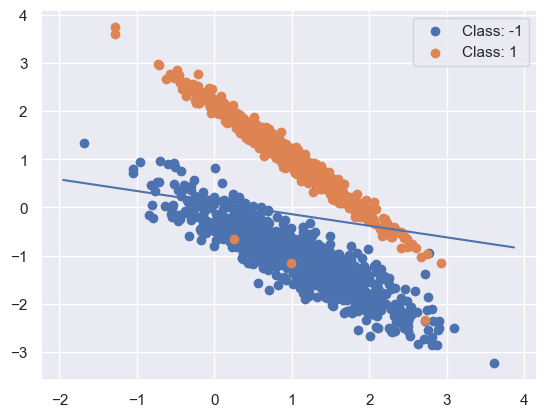

In [36]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [37]:
def plot_loss_history(model):
    """
    Рисует график значения функции потерь
    в зависимости от номера итерации SGD обучения.
    """
    if model.loss_history_ is None or len(model.loss_history_) == 0:
        raise ValueError("Model must be fitted before plotting loss history!")

    plt.figure()
    plt.plot(range(1, len(model.loss_history_) + 1), model.loss_history_)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss over iterations")
    plt.grid(True)
    plt.show()

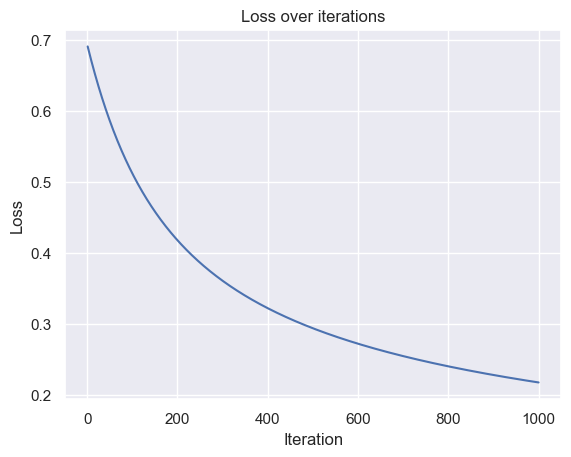

In [38]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Разделение данных на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Убедимся, что классы 0/1
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

kernels = ["linear", "rbf", "poly"]
C_values = [0.1, 1, 10, 100]

results = []

for kernel in kernels:
    for C in C_values:
        model = SVC(kernel=kernel, C=C, probability=True, random_state=42)
        model.fit(X_train, y_train_enc)

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        results.append({
            "Kernel": kernel,
            "C": C,
            "Accuracy": accuracy_score(y_test_enc, y_pred),
            "Precision": precision_score(y_test_enc, y_pred),
            "Recall": recall_score(y_test_enc, y_pred),
            "F1-score": f1_score(y_test_enc, y_pred),
            "AUC-ROC": roc_auc_score(y_test_enc, y_proba)
        })

df_svc_results = pd.DataFrame(results)
df_svc_results

,Kernel,C,Accuracy,Precision,Recall,F1-score,AUC-ROC
0,linear,0.1,0.993333,0.991150,0.995556,0.993348,0.994963
1,linear,1.0,0.993333,0.991150,0.995556,0.993348,0.995121
2,linear,10.0,0.993333,0.991150,0.995556,0.993348,0.995516
3,linear,100.0,0.993333,0.991150,0.995556,0.993348,0.995516
4,rbf,0.1,0.995556,0.995556,0.995556,0.995556,0.997432
5,rbf,1.0,0.995556,0.995556,0.995556,0.995556,0.997827
6,rbf,10.0,0.993333,0.991150,0.995556,0.993348,0.997669
7,rbf,100.0,0.995556,0.995556,0.995556,0.995556,0.996681
8,poly,0.1,0.995556,0.995556,0.995556,0.995556,0.991585
9,poly,1.0,0.995556,0.995556,0.995556,0.995556,0.992672


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

{'Accuracy': 0.9577777777777777, 'Precision': 0.9692132269099202, 'Recall': 0.9454949944382648, 'F1-score': 0.9572072072072072, 'AUC-ROC': 0.9896888761591064}


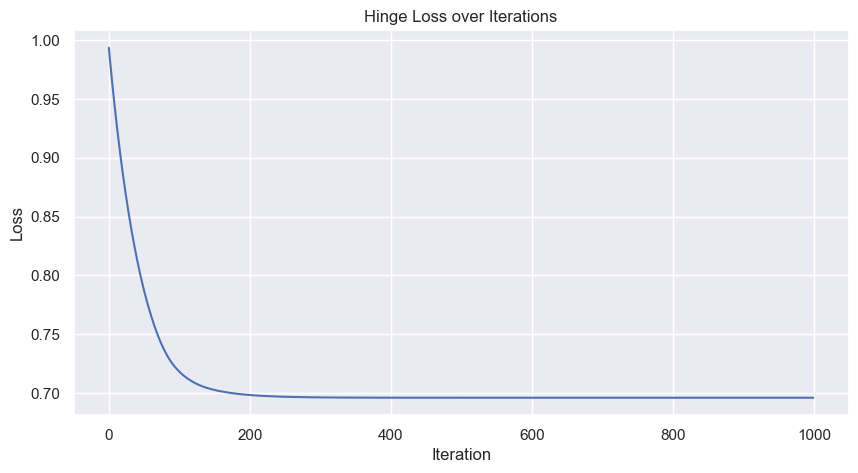

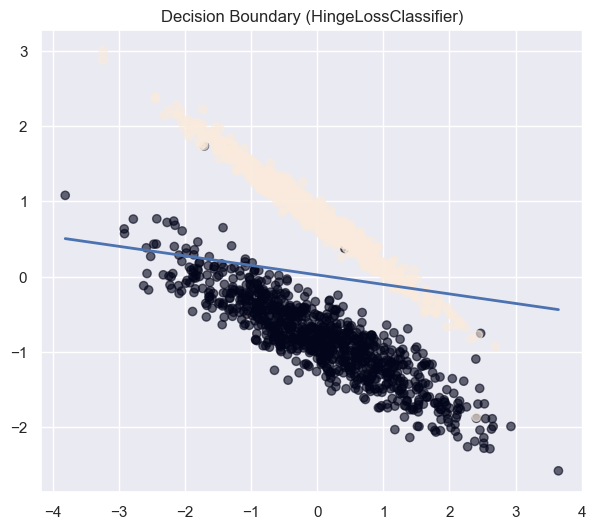

In [49]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Наш датасет
X, y = make_classification(
    n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
    random_state=42, n_clusters_per_class=1
)

# Переводим метки {0,1} -> {-1,+1}
y_signed = np.where(y == 0, -1, 1)

# Нормируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


class HingeLossClassifier:

    def __init__(self, lr=0.01, max_iter=1000, C=1.0):
        """
        C — коэффициент штрафа (как в SVM)
        lr — скорость обучения
        max_iter — число итераций
        """
        self.lr = lr
        self.max_iter = max_iter
        self.C = C
        self.loss_history = None
        self.w = None
        self.b = None

    def hinge_loss(self, X, y):
        margins = y * (X.dot(self.w) + self.b)
        return np.mean(np.maximum(0, 1 - margins)) + (1 / (2 * self.C)) * np.sum(self.w ** 2)

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        self.loss_history = []

        for _ in range(self.max_iter):
            margins = y * (X.dot(self.w) + self.b)
            misclassified = margins < 1

            grad_w = -np.mean((misclassified * y)[:, None] * X, axis=0) + (1 / self.C) * self.w
            grad_b = -np.mean(misclassified * y)

            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b

            self.loss_history.append(self.hinge_loss(X, y))

        return self

    def predict(self, X):
        return np.where(X.dot(self.w) + self.b >= 0, 1, 0)


# Обучаем
model = HingeLossClassifier(lr=0.01, max_iter=1000, C=1.0)
model.fit(X_scaled, y_signed)

y_pred = model.predict(X_scaled)
y_prob = (X_scaled.dot(model.w) + model.b - np.min(X_scaled.dot(model.w) + model.b)) / \
         (np.max(X_scaled.dot(model.w) + model.b) - np.min(X_scaled.dot(model.w) + model.b))


# Метрики
metrics = {
    "Accuracy": accuracy_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "F1-score": f1_score(y, y_pred),
    "AUC-ROC": roc_auc_score(y, y_prob),
}
print(metrics)

plt.figure(figsize=(10, 5))
plt.plot(model.loss_history)
plt.title("Hinge Loss over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, alpha=0.6)
x_vals = np.linspace(min(X_scaled[:, 0]), max(X_scaled[:, 0]), 100)
y_vals = -(model.w[0] * x_vals + model.b) / model.w[1]
plt.plot(x_vals, y_vals, linewidth=2)
plt.title("Decision Boundary (HingeLossClassifier)")
plt.show()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

{'Accuracy': 0.9955555555555555, 'Precision': 0.9944506104328524, 'Recall': 0.996662958843159, 'F1-score': 0.9955555555555555, 'AUC-ROC': 0.999920370272062}


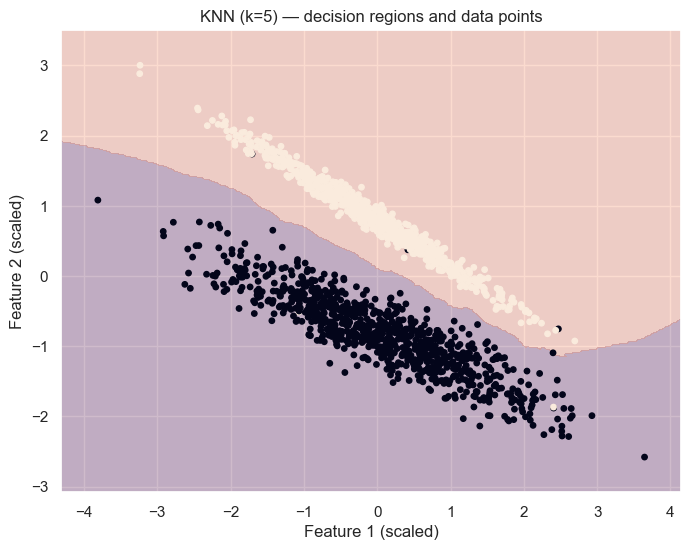

In [51]:
from collections import Counter

# Наши данные
X, y = make_classification(
    n_samples=1800,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=42,
    n_clusters_per_class=1
)

# Масштабирование признаков (KNN чувствителен к масштабу)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        
        self.n_neighbors = int(n_neighbors)
        self.metric = metric
        # будут заполнены в fit
        self.X_train = None
        self.y_train = None
        self.classes_ = None

    def fit(self, X, y):
        
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        if X.ndim != 2:
            raise ValueError("X must be 2D array")
        if X.shape[0] != y.shape[0]:
            raise ValueError("X and y must have same number of samples")
        self.X_train = X.copy()
        self.y_train = y.copy()
        # сохраним уникальные классы (в порядке сортировки)
        self.classes_, _ = np.unique(self.y_train, return_inverse=True)
        return self

    def _compute_distances(self, X):
        """
        Вычисляет матрицу расстояний между X (n_query, n_features)
        и обучающей выборкой self.X_train (n_train, n_features).
        Возвращает distances shape (n_query, n_train).
        Реализовано через скалярные произведения.
        """
        if self.X_train is None:
            raise ValueError("Fit must be called before predict.")
        X = np.asarray(X, dtype=float)

        # ||a-b||^2 = ||a||^2 + ||b||^2 - 2 a.b
        a2 = np.sum(X**2, axis=1)[:, None]              # (n_query, 1)
        b2 = np.sum(self.X_train**2, axis=1)[None, :]   # (1, n_train)
        ab = X.dot(self.X_train.T)                      # (n_query, n_train)
        d2 = a2 + b2 - 2.0 * ab
        d2 = np.maximum(d2, 0.0)  # исправление численных погрешностей
        distances = np.sqrt(d2)
        return distances

    def predict_proba(self, X):
        """
        Для каждого объекта возвращает вероятности принадлежности ко всем классам
        P(class_i) = (#neighbors_of_class_i) / k
        Возвращает массив shape (n_query, n_classes) в порядке self.classes_
        """
        X = np.asarray(X, dtype=float)
        distances = self._compute_distances(X)  # (n_query, n_train)
        n_query = distances.shape[0]
        n_classes = self.classes_.shape[0]
        proba = np.zeros((n_query, n_classes), dtype=float)

        k = min(self.n_neighbors, self.X_train.shape[0])  # на случай малого train
        # argpartition быстрее, чем полное сортирование
        neigh_idx = np.argpartition(distances, kth=k-1, axis=1)[:, :k]  # (n_query, k)

        for i in range(n_query):
            idx = neigh_idx[i]
            neigh_labels = self.y_train[idx]
            counts = Counter(neigh_labels)
            # заполнение в порядке self.classes_
            for j, cls in enumerate(self.classes_):
                proba[i, j] = counts.get(cls, 0) / k

        return proba

    def predict(self, X):
        """
        Предсказание класса: выбираем класс с максимальной вероятностью.
        Возвращает массив меток в исходном формате y_train.
        """
        proba = self.predict_proba(X)
        idx = np.argmax(proba, axis=1)
        return self.classes_[idx]


# Тестирование
knn = KNNClassifier(n_neighbors=5)
knn.fit(X_scaled, y)

# Предсказания и вероятности
y_pred_knn = knn.predict(X_scaled)
proba_knn = knn.predict_proba(X_scaled)

# Вычисление метрик
metrics_knn = {
    "Accuracy": accuracy_score(y, y_pred_knn),
    "Precision": precision_score(y, y_pred_knn),
    "Recall": recall_score(y, y_pred_knn),
    "F1-score": f1_score(y, y_pred_knn),
    "AUC-ROC": roc_auc_score(y, proba_knn[:, 1])
}

print(metrics_knn)


# Построим сетку по признакам и вычислим вероятности для каждой точки сетки
x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_proba = knn.predict_proba(grid)[:, 1].reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_proba, levels=[-0.01, 0.5, 1.01], alpha=0.3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, s=15)
plt.title("KNN (k=5) — decision regions and data points")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

# Пути к CSV
train_path = "fashion-mnist_train.csv"
test_path  = "fashion-mnist_test.csv"

# Загружаем и объединяем данные
df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Определяем столбец с метками
label_col = 'label' if 'label' in df_all.columns else df_all.columns[0]
y = df_all[label_col].values

# Стратифицированное разделение (фиксируем random_state)
splitter = StratifiedShuffleSplit(n_splits=1, train_size=50000, random_state=42)
train_idx, test_idx = next(splitter.split(df_all, y))

df_train_split = df_all.iloc[train_idx].reset_index(drop=True)
df_test_split  = df_all.iloc[test_idx].reset_index(drop=True)

#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

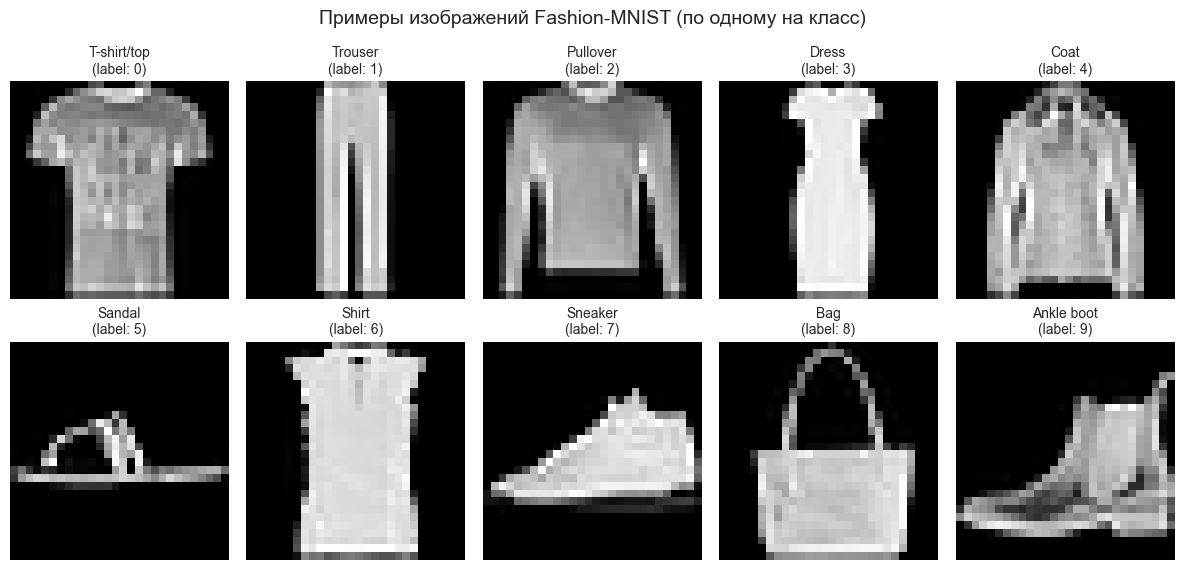

In [57]:
label_col = 'label' if 'label' in df_train_split.columns else df_train_split.columns[0]

data = df_train_split.copy()

# Отделяем метки и признаки
y = data[label_col].values
X = data.drop(columns=[label_col]).values

# Размер одного изображения
img_size = int(np.sqrt(X.shape[1]))  # должно получиться 28

# Названия классов Fashion-MNIST
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Список уникальных классов
classes = np.unique(y)

# Визуализация по одному примеру каждого класса
plt.figure(figsize=(12, 6))
for idx, cls in enumerate(classes):
    # Берём первый пример класса
    img_vector = X[y == cls][0]
    img = img_vector.reshape(img_size, img_size)

    plt.subplot(2, 5, idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"{class_names[int(cls)]}\n(label: {cls})", fontsize=10)
    plt.axis("off")

plt.suptitle("Примеры изображений Fashion-MNIST (по одному на класс)", fontsize=14)
plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [59]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Определяем столбец с метками
label_col = 'label' if 'label' in df_train_split.columns else df_train_split.columns[0]

# Разделяем признаки и метки
X_train = df_train_split.drop(columns=[label_col]).values
y_train = df_train_split[label_col].values

X_test = df_test_split.drop(columns=[label_col]).values
y_test = df_test_split[label_col].values

# Вариант 1: StandardScaler
scaler_std = StandardScaler()
X_train_std = scaler_std.fit_transform(X_train)
X_test_std = scaler_std.transform(X_test)

# Вариант 2: MinMaxScaler
scaler_mm = MinMaxScaler()
X_train_mm = scaler_mm.fit_transform(X_train)
X_test_mm = scaler_mm.transform(X_test)

# Проверим результаты
print("StandardScaler:")
print("  mean (первые 5):", np.round(X_train_std.mean(axis=0)[:5], 4))
print("  std  (первые 5):", np.round(X_train_std.std(axis=0)[:5], 4))

print("\nMinMaxScaler:")
print("  min (первые 5):", np.round(X_train_mm.min(axis=0)[:5], 4))
print("  max (первые 5):", np.round(X_train_mm.max(axis=0)[:5], 4))

# Сохраняем обратно в DataFrame
df_train_std = pd.DataFrame(X_train_std, columns=df_train_split.columns.drop(label_col))
df_train_std[label_col] = y_train

df_test_std = pd.DataFrame(X_test_std, columns=df_test_split.columns.drop(label_col))
df_test_std[label_col] = y_test

df_train_mm = pd.DataFrame(X_train_mm, columns=df_train_split.columns.drop(label_col))
df_train_mm[label_col] = y_train

df_test_mm = pd.DataFrame(X_test_mm, columns=df_test_split.columns.drop(label_col))
df_test_mm[label_col] = y_test

StandardScaler:
  mean (первые 5): [-0. -0.  0.  0. -0.]
  std  (первые 5): [1. 1. 1. 1. 1.]

MinMaxScaler:
  min (первые 5): [0. 0. 0. 0. 0.]
  max (первые 5): [1. 1. 1. 1. 1.]


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report


# Используем отнормированные данные
X_train = df_train_std.drop(columns=['label']).values
y_train = df_train_std['label'].values
X_test = df_test_std.drop(columns=['label']).values
y_test = df_test_std['label'].values


# GridSearch для LogisticRegression


param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [200]
}

lr = LogisticRegression()
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_lr.fit(X_train, y_train)

best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
acc_lr = accuracy_score(y_test, y_pred_lr)

print("    Logistic Regression    ")
print("Лучшие параметры:", grid_lr.best_params_)
print("Accuracy на тесте:", round(acc_lr, 4))
print("\nОтчёт классификации:\n", classification_report(y_test, y_pred_lr))

# Визуализация зависимости Accuracy от C
results_lr = pd.DataFrame(grid_lr.cv_results_)
subset_lr = results_lr.groupby('param_C')['mean_test_score'].max()

plt.figure(figsize=(6,4))
plt.plot(subset_lr.index, subset_lr.values, marker='o')
plt.xscale('log')
plt.title('Зависимость Accuracy от C (Logistic Regression)')
plt.xlabel('C')
plt.ylabel('Средняя accuracy (5-fold)')
plt.grid(True)
plt.show()


# GridSearch для KNeighborsClassifier


param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)

print("\n    KNN Classifier    ")
print("Лучшие параметры:", grid_knn.best_params_)
print("Accuracy на тесте:", round(acc_knn, 4))
print("\nОтчёт классификации:\n", classification_report(y_test, y_pred_knn))

# Визуализация зависимости Accuracy от n_neighbors
results_knn = pd.DataFrame(grid_knn.cv_results_)
subset_knn = results_knn.groupby('param_n_neighbors')['mean_test_score'].max()

plt.figure(figsize=(6,4))
plt.plot(subset_knn.index, subset_knn.values, marker='o')
plt.title('Зависимость Accuracy от k (KNN)')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Средняя accuracy (5-fold)')
plt.grid(True)
plt.show()

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
Логистическая регрессия вычисляет вероятность класса 1 как сигмоида от линейной комбинации признаков, где параметры модели w₁, w₂ 
и смещение b. Потери вычисляются через кросс-энтропию.

Так как все строки признаков одинаковы, модель видит одну точку, принадлежащую двум классам одновременно, что невозможно разделить. 
Градиенты для объектов разных классов направлены в противоположные стороны: шаг для класса 1 увеличивает значение линейной комбинации, для класса 0 уменьшает.

Следствие: SGD не сойдётся к устойчивым весам, параметры будут колебаться. Предсказания для всех объектов примерно 0.5, отражая максимум неопределённости.

Вывод: логистическая регрессия на таких данных не обучается, веса нестабильны, предсказания всех объектов стремятся к 0.5.